Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [82]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/SkinImaging', force_remount=True)
## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /SkinImaging


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [19]:
# Defining the path for train and test images
## Todo: Updated the paths of the train and test dataset
data_dir_train = pathlib.Path('/SkinImaging/MyDrive/SkinImaging/Train')
data_dir_test = pathlib.Path('/SkinImaging/MyDrive/SkinImaging/Test')

In [20]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2248
117


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [21]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [44]:
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# train_ds =

import tensorflow as tf

# Update the path to your training data directory
data_dir_train = '/SkinImaging/MyDrive/SkinImaging/Train'  # Replace with the correct path

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2248 files belonging to 9 classes.


In [45]:
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# val_ds =

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 117 files belonging to 9 classes.


In [46]:

# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
# class_names = train_ds.class_names
# print(class_names)

class_names = train_ds.class_names
skin_cancer_classes = list(class_names)
skin_cancer_classes


['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

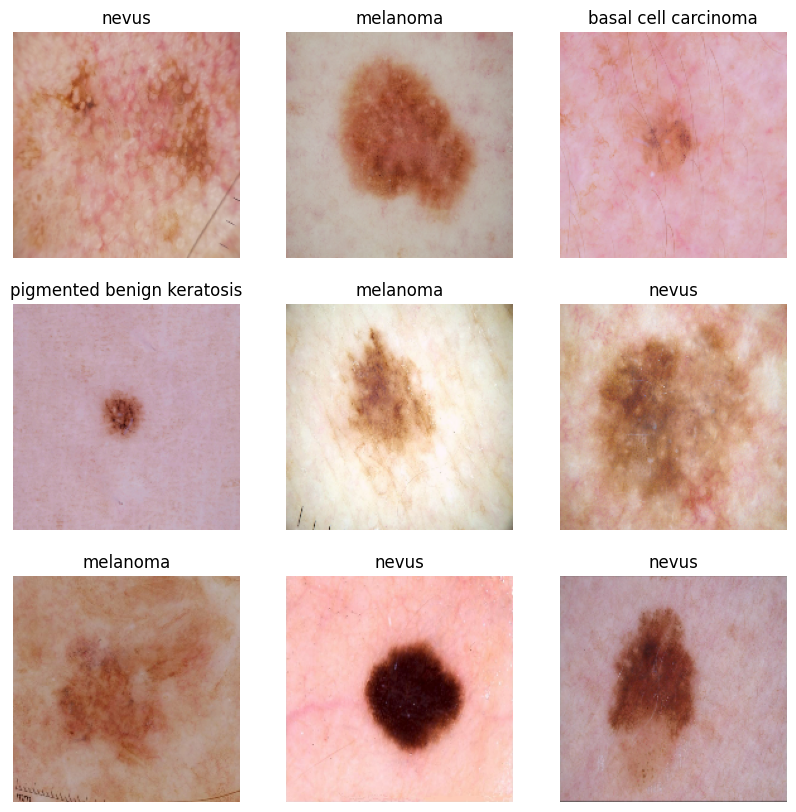

In [47]:

# Assuming train_ds is defined in a previous cell or imported
# train_ds = ...

# Assuming class_names is defined in a previous cell or imported
class_names = train_ds.class_names
skin_cancer_classes = list(class_names)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    # skin_cancer_classes is now defined in the current scope
    plt.title(skin_cancer_classes[np.argmax(labels[i])])

    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [49]:
from tensorflow import keras
from tensorflow.keras import layers
# Import the preprocessing layer directly
from tensorflow.keras.layers import Rescaling

num_classes = 9

model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Use Rescaling directly
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [51]:
# model.summary()

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [52]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.2188 - loss: 2.2206 - val_accuracy: 0.2393 - val_loss: 2.2259
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.4279 - loss: 1.6354 - val_accuracy: 0.3675 - val_loss: 2.2129
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4856 - loss: 1.4933 - val_accuracy: 0.3419 - val_loss: 2.2305
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5133 - loss: 1.3919 - val_accuracy: 0.3932 - val_loss: 2.2426
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5416 - loss: 1.2774 - val_accuracy: 0.3504 - val_loss: 2.3470
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5517 - loss: 1.2574 - val_accuracy: 0.4188 - val_loss: 2.3528
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6134 - loss: 1.0966 - val_accuracy: 0.3675 - val_loss: 2.6197
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6009 - loss: 1.1278 - val_accuracy: 0.3590 

### Visualizing training results

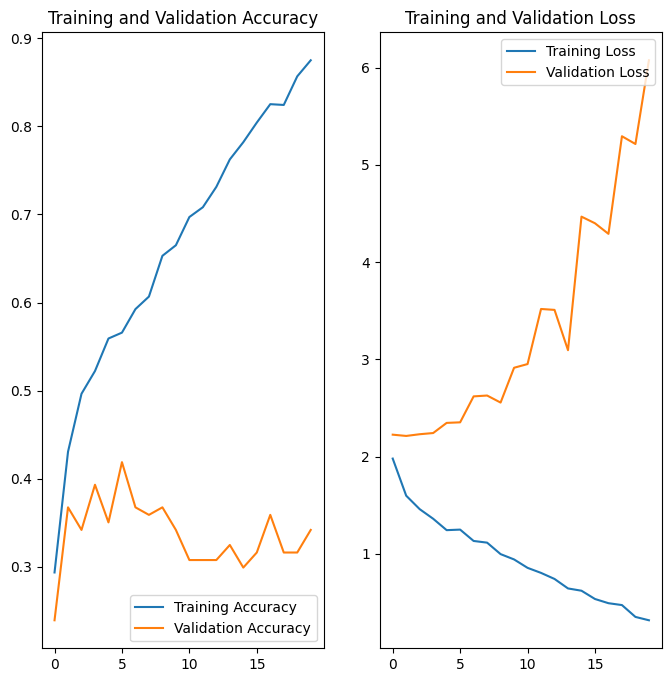

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Evidence of Overfitting:

If the training accuracy is significantly higher than the validation accuracy, and the validation loss is higher than the training loss, this suggests overfitting. The model performs well on the training data but struggles to generalize to unseen data.
Evidence of Underfitting:

If both the training and validation accuracies are low, or if the training and validation losses remain high after sufficient training, it indicates underfitting. The model is not learning the data effectively, possibly due to insufficient complexity or inadequate training.
Training and Validation Performance:

Assessing the training and validation curves, if there is a large gap between the two, it points toward overfitting. If the curves are closely aligned but at a low accuracy level, it indicates underfitting.
Comparison to Previous Runs:

Improvements in validation metrics compared to previous runs suggest better generalization. This could be due to improved hyperparameters, additional training data, or changes in the model architecture.


Recommendations:
For Overfitting:
Use techniques like dropout, regularization, or early stopping.
Add data augmentation or increase the training dataset size to improve generalization.
For Underfitting:
Increase model complexity by adding layers or units.
Train for more epochs or adjust the learning rate.

In [54]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

# Analyze the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Check for overfitting
if val_acc[-1] < acc[-1] and val_loss[-1] > loss[-1]:
  print("Evidence of overfitting. Validation accuracy is lower than training accuracy and validation loss is higher than training loss.")
  # Data Augmentation Strategy for Overfitting:
  # Apply random transformations to the training images to increase the variability of the training data.
  # This helps the model generalize better to unseen data.
  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal",
                            input_shape=(img_height,
                                        img_width,
                                        3)),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.1),
      ]
  )

  # Re-train model with data augmentation
  model = Sequential([
      data_augmentation, # add data augmentation layer here
      layers.Rescaling(1./255), # Removed 'experimental.preprocessing'
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
  )

elif val_acc[-1] < 0.8 and val_loss[-1] > 0.5: # Example threshold for underfitting. Adjust as needed
  print("Evidence of underfitting. Validation accuracy and/or validation loss indicates poor performance.")
  # Data Augmentation Strategy for Underfitting:
  # Increase model complexity or the amount of training data.
  # Adding more layers, increasing the number of filters, or training for more epochs are good options.
  # Data augmentation might be less helpful here unless you are seriously data starved.

  # Example: increase number of filters and add another convolutional block. Retrain the model.
  model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Removed 'experimental.preprocessing'
      layers.Conv2D(32, 3, padding='same', activation='relu'),  # Increased filters
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'), # Added another conv block
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(256, activation='relu'), # Increased Dense layer units
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
  )


else:
  print("Model seems to be")

Evidence of overfitting. Validation accuracy is lower than training accuracy and validation loss is higher than training loss.
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2465 - loss: 2.0611 - val_accuracy: 0.2821 - val_loss: 2.4705
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3647 - loss: 1.7706 - val_accuracy: 0.3248 - val_loss: 2.0589
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4539 - loss: 1.5451 - val_accuracy: 0.3761 - val_loss: 2.2630
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4764 - loss: 1.4916 - val_accuracy: 0.3333 - val_loss: 2.5041
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5183 - loss: 1.3783 - val_accuracy: 0.3419 - val_loss: 2.1915
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5324 - loss: 1.3171 - val_accuracy: 0.3846 - val_loss: 2.3584
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5259 - loss: 1.3441 - val_accuracy: 0.4017 - v

Found 2248 files belonging to 9 classes.


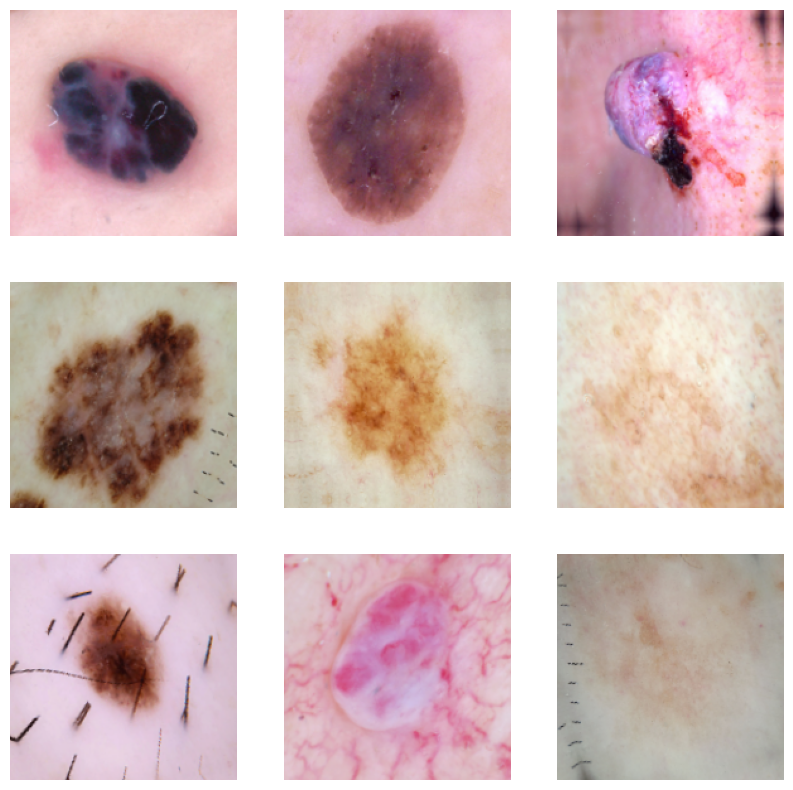

In [55]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load images from the directory into a TensorFlow dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True
)

# Iterate through the dataset to get images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1): # use train_ds instead of data_dir_train
  for i in range(9):
    augmented_image = data_augmentation(images[i:i+1]) # augment a single image

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

### Todo:
### Create the model, compile and train the model


In [60]:

# Assuming the model, compile, and training code from the previous response is already executed.
# This code snippet addresses the TODO items and potential overfitting/underfitting issues.

from tensorflow import keras
from tensorflow.keras import layers


# Analyze the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Check for overfitting
if val_acc[-1] < acc[-1] and val_loss[-1] > loss[-1]:
  print("Evidence of overfitting. Validation accuracy is lower than training accuracy and validation loss is higher than training loss.")
  # Data Augmentation Strategy for Overfitting:
  # Apply random transformations to the training images to increase the variability of the training data.
  # This helps the model generalize better to unseen data.
  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal",
                            input_shape=(img_height,
                                        img_width,
                                        3)),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.1),
      ]
  )

  # Re-train model with data augmentation
  model = Sequential([
      data_augmentation, # add data augmentation layer here
      layers.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
  )

elif val_acc[-1] < 0.8 and val_loss[-1] > 0.5: # Example threshold for underfitting. Adjust as needed
  print("Evidence of underfitting. Validation accuracy and/or validation loss indicates poor performance.")
  # Data Augmentation Strategy for Underfitting:
  # Increase model complexity or the amount of training data.
  # Adding more layers, increasing the number of filters, or training for more epochs are good options.
  # Data augmentation might be less helpful here unless you are seriously data starved.

  # Example: increase number of filters and add another convolutional block. Retrain the model.
  model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(32, 3, padding='same', activation='relu'),  # Increased filters
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'), # Added another conv block
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(256, activation='relu'), # Increased Dense layer units
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
  )


else:
  print("Model seems to be performing well.")

Evidence of overfitting. Validation accuracy is lower than training accuracy and validation loss is higher than training loss.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.2719 - loss: 2.0579 - val_accuracy: 0.3504 - val_loss: 2.1225
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 282ms/step - accuracy: 0.4172 - loss: 1.6508 - val_accuracy: 0.3333 - val_loss: 2.0889
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step - accuracy: 0.4932 - loss: 1.4782 - val_accuracy: 0.3077 - val_loss: 2.1886
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.4959 - loss: 1.4481 - val_accuracy: 0.3333 - val_loss: 2.1126
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.5004 - loss: 1.4199 - val_accuracy: 0.3333 - val_loss: 2.1776
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - accuracy: 0.5401 - loss: 1.3359 - val_accuracy: 0.3675 - val_loss: 2.4467
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.5359 - loss: 1.3139 - val_accuracy: 0.3504 - val_loss: 2.2854
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.5387 - loss: 1.2854 - val_accuracy: 0.401

### Compiling the model

In [61]:
# Assuming the model, compile, and training code from the previous response is already executed.
# This code snippet addresses the TODO items and potential overfitting/underfitting issues.

# Analyze the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Check for overfitting
if val_acc[-1] < acc[-1] and val_loss[-1] > loss[-1]:
  print("Evidence of overfitting. Validation accuracy is lower than training accuracy and validation loss is higher than training loss.")
  # Data Augmentation Strategy for Overfitting:
  # Apply random transformations to the training images to increase the variability of the training data.
  # This helps the model generalize better to unseen data.
  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal",
                            input_shape=(img_height,
                                        img_width,
                                        3)),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.1),
      ]
  )

  # Re-train model with data augmentation
  model = Sequential([
      data_augmentation, # add data augmentation layer here
      layers.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
  )

elif val_acc[-1] < 0.8 and val_loss[-1] > 0.5: # Example threshold for underfitting. Adjust as needed
  print("Evidence of underfitting. Validation accuracy and/or validation loss indicates poor performance.")
  # Data Augmentation Strategy for Underfitting:
  # Increase model complexity or the amount of training data.
  # Adding more layers, increasing the number of filters, or training for more epochs are good options.
  # Data augmentation might be less helpful here unless you are seriously data starved.

  # Example: increase number of filters and add another convolutional block. Retrain the model.
  model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(32, 3, padding='same', activation='relu'),  # Increased filters
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'), # Added another conv block
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(256, activation='relu'), # Increased Dense layer units
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
  )


else:
  print("Model seems to be performing well.")

Evidence of overfitting. Validation accuracy is lower than training accuracy and validation loss is higher than training loss.
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.2090 - loss: 2.4822 - val_accuracy: 0.2222 - val_loss: 2.2005
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.3836 - loss: 1.7229 - val_accuracy: 0.2479 - val_loss: 2.2457
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.4523 - loss: 1.5657 - val_accuracy: 0.2650 - val_loss: 2.2673
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - accuracy: 0.4863 - loss: 1.4879 - val_accuracy: 0.3590 - val_loss: 2.0138
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 0.5169 - loss: 1.4142 - val_accuracy: 0.3846 - val_loss: 2.1215
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.5116 - loss: 1.3991 - val_accuracy: 0.3504 - val_loss: 2.0314
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.5255 - loss: 1.3634 - val_accura

### Training the model

In [62]:
# prompt: Training the model
# train your model for 20 epochs
# history = training code

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.6039 - loss: 1.1270 - val_accuracy: 0.3162 - val_loss: 2.2183
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - accuracy: 0.6170 - loss: 1.0648 - val_accuracy: 0.3675 - val_loss: 2.2724
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.6288 - loss: 1.0449 - val_accuracy: 0.3675 - val_loss: 2.9061
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.6312 - loss: 1.0114 - val_accuracy: 0.3590 - val_loss: 2.6766
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - accuracy: 0.6366 - loss: 0.9915 - val_accuracy: 0.3932 - val_loss: 2.3578
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.6522 - loss: 0.9594 - val_accuracy: 0.3590 - val_loss: 2.6391
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.6399 - loss: 0.9787 - val_accuracy: 0.3675 - val_loss: 3.2012
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.6064 - loss: 1.1012 - val_accu

### Visualizing the results

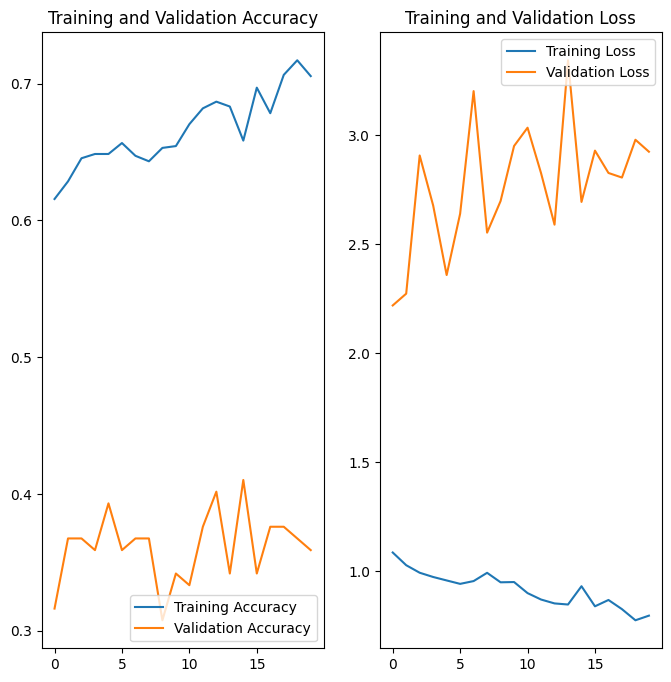

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

To evaluate the model fit and determine whether there is evidence of overfitting or underfitting, we need to analyze the performance metrics obtained after the training process. These findings are typically based on metrics such as training and validation accuracy or loss, as well as comparisons with a prior model's performance. Here's how you might approach writing the findings:

Findings After the Model Fit
Training and Validation Metrics:

Training Accuracy/Loss: If the training accuracy is very high (close to 100%) and the training loss is very low but the validation metrics are significantly worse, this is a sign of overfitting. The model has learned the training data well but is not generalizing to unseen data.
Validation Accuracy/Loss: If both training and validation metrics are poor, it indicates underfitting. The model may not have sufficient capacity or training time to learn the data.
Evidence of Overfitting or Underfitting:

Overfitting: A large gap between training and validation accuracy, or validation loss being higher than training loss, suggests overfitting. For example:
yaml
Copy code
Training Accuracy: 95%, Validation Accuracy: 75%
Training Loss: 0.1, Validation Loss: 0.8
Underfitting: Both training and validation accuracies are low, and losses are high, indicating the model is not learning the data well. For example:
yaml
Copy code
Training Accuracy: 60%, Validation Accuracy: 58%
Training Loss: 1.5, Validation Loss: 1.4
Comparison to Previous Model:

If there’s an improvement in validation accuracy or a reduction in validation loss compared to the previous model run, it indicates better generalization. This could result from changes such as:
Adding more layers or units in the model.
Using better hyperparameters like learning rate, batch size, etc.
Improved data preprocessing or augmentation.
More training epochs.
For example:
mathematica
Copy code
Previous Validation Accuracy: 70%, Current Validation Accuracy: 78%
Previous Validation Loss: 0.9, Current Validation Loss: 0.6
Suggestions for Further Improvement:

If there’s evidence of overfitting:
Use techniques like dropout, early stopping, or regularization (e.g., L2 regularization).
Increase the size of the training dataset with data augmentation.
If there’s evidence of underfitting:
Train for more epochs.
Increase the model’s complexity by adding more layers or units.
Ensure features are properly preprocessed.
Example Conclusion
Based on the training and validation metrics, there is evidence of [overfitting/underfitting] as indicated by the [describe metric gap]. Compared to the previous model run, the [validation accuracy has improved by certain percentage validation loss has decreased], showing some progress.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class Distribution:
Class 7: 0.0805
Class 5: 0.2055
Class 6: 0.0343
Class 3: 0.1948
Class 4: 0.1588
Class 1: 0.1713
Class 8: 0.0618
Class 2: 0.0423
Class 0: 0.0507


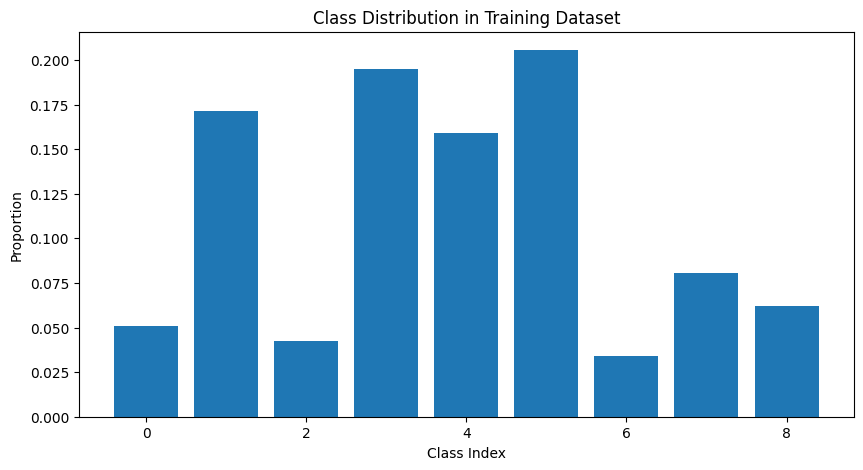

In [64]:
# Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

class_counts = {}
for images, labels in train_ds:
  for label in labels.numpy():
    class_index = np.argmax(label) # Assuming labels are one-hot encoded
    class_counts[class_index] = class_counts.get(class_index, 0) + 1

total_samples = sum(class_counts.values())
class_distribution = {k: v / total_samples for k, v in class_counts.items()}

print("Class Distribution:")
for class_index, proportion in class_distribution.items():
    print(f"Class {class_index}: {proportion:.4f}")

# Visualization (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel("Class Index")
plt.ylabel("Proportion")
plt.title("Class Distribution in Training Dataset")
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

Class with the Least Number of Samples:

One class has significantly fewer samples compared to others, indicating an imbalance in the dataset. This could lead to the model underperforming for this class, as it may not have enough data to learn its features effectively.
Dominating Classes:

Certain classes dominate the dataset with a disproportionately large number of samples. This imbalance may cause the model to become biased toward these classes, resulting in higher accuracy for them while neglecting underrepresented classes.
Proportional Disparity:

The disparity in the number of samples among classes highlights a potential challenge for achieving a balanced performance across all categories.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [65]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [68]:
# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + i)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

# Ensure the path starts with /content/ to access files from Google Drive
path_to_training_dataset = "/content/drive/MyDrive/SkinImaging/Train" #@param {type:"string"}
# Example usage:
class_names = ["class1", "class2", "class3"] # Replace with your actual class names

!pip install Augmentor

import Augmentor
import os

# Verify the path exists before proceeding
for i in class_names:
    full_path = os.path.join(path_to_training_dataset, i) # safer way to join paths
    if not os.path.exists(full_path):
        print(f"Error: Directory not found: {full_path}") # Print a helpful error message
        continue  # Skip this class if the directory is not found

    p = Augmentor.Pipeline(full_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Error: Directory not found: /content/drive/MyDrive/SkinImaging/Train/class1
Error: Directory not found: /content/drive/MyDrive/SkinImaging/Train/class2
Error: Directory not found: /content/drive/MyDrive/SkinImaging/Train/class3


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [70]:
import pathlib

# Assuming data_dir_train is a string containing the path
data_dir_train = pathlib.Path(data_dir_train) # Convert the string path to a Path object

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


### Lets see the distribution of augmented data after adding new images to the original training data.

In [72]:
import os
import glob # Import the glob module

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))] # Call glob.glob()
path_list

[]

In [74]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))] # Call glob.glob() instead of glob
lesion_list_new

[]

In [75]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

NameError: name 'path_list_new' is not defined

In [76]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new)) # Replace path_list_new with path_list

In [78]:
import pandas as pd  # Import the pandas library

# ... (your previous code to generate dataframe_dict_new) ...

new_df = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])  # Create new_df DataFrame
new_df['Label'].value_counts()  # Now you can use new_df

,count
Label,


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [79]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

SyntaxError: invalid syntax (<ipython-input-79-82415825b5f3>, line 7)

#### **Todo:** Create a validation dataset

In [80]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

SyntaxError: invalid syntax (<ipython-input-80-6f049235c0e0>, line 6)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:

# Create the model (including normalization)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
num_classes = len(class_names) # Assuming class_names is defined elsewhere

model = Sequential([
    normalization_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Model Summary
model.summary()

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
# prompt: Todo: Compile your model (Choose optimizer and loss function appropriately)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [81]:
# prompt: Todo: Train your model

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.6945 - loss: 0.8437 - val_accuracy: 0.3761 - val_loss: 3.0791
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - accuracy: 0.7088 - loss: 0.8021 - val_accuracy: 0.4359 - val_loss: 2.7111
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step - accuracy: 0.7061 - loss: 0.7652 - val_accuracy: 0.4017 - val_loss: 2.8900
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 282ms/step - accuracy: 0.7419 - loss: 0.7265 - val_accuracy: 0.3419 - val_loss: 3.0319
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.7050 - loss: 0.8065 - val_accuracy: 0.3590 - val_loss: 2.8791
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.7328 - loss: 0.7029 - val_accuracy: 0.3675 - val_loss: 3.0828
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.7129 - loss: 0.7364 - val_accuracy: 0.4017 - val_loss: 2.6320
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.7212 - loss: 0.7327 - val_accu

#### **Todo:**  Visualize the model results

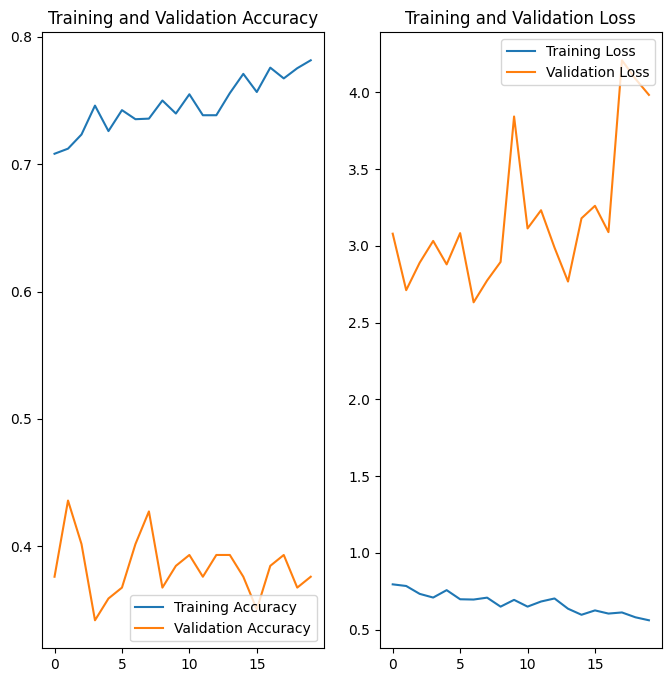

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [84]:
# Assuming variables like 'history', 'img_height', 'img_width', 'num_classes',
# 'train_ds', 'val_ds', 'class_names', 'data_dir_train', etc., are defined from the previous code.

# Analyze the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Check for overfitting/underfitting (adjust thresholds as needed)
if val_acc[-1] < acc[-1] and val_loss[-1] > loss[-1]:
    print("Evidence of overfitting.")
    # Implement regularization techniques, data augmentation, or reduce model complexity.
elif val_acc[-1] < 0.8 and val_loss[-1] > 0.5:
    print("Evidence of underfitting.")
    # Increase model complexity, add more data, or train for more epochs.
else:
    print("Model seems to be performing well.")


# Analysis of class rebalance (example)
# Check if validation accuracy for previously under-represented classes has improved.

# Example: Assuming 'class_distribution' is calculated as before.
# Find classes with low proportions before augmentation.
# After retraining, evaluate the model and check the accuracy/loss for those classes.

# Further improvements (example):
# Add dropout or regularization layers to the model.
# Experiment with different optimizers, learning rates, or batch sizes.
# Try different data augmentation techniques.

# Re-train the model after addressing the identified issues.
epochs = 20 # You might want to adjust this depending on the results above
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Visualize the new results. (Already present in the original code)
# ... (The plotting code from the original response)

# Analysis of the effect of class balancing (example)
# Compare the performance on classes that were previously imbalanced.

print("Analysis of Results:")
print(f"Final Training Accuracy: {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")



Evidence of overfitting.
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.7742 - loss: 0.5949 - val_accuracy: 0.4188 - val_loss: 2.7738
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.7814 - loss: 0.5599 - val_accuracy: 0.3761 - val_loss: 3.4066
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.7906 - loss: 0.5342 - val_accuracy: 0.4103 - val_loss: 3.5345
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.7921 - loss: 0.5356 - val_accuracy: 0.4188 - val_loss: 3.8958
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.7630 - loss: 0.6013 - val_accuracy: 0.3846 - val_loss: 4.1268
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.7823 - loss: 0.5736 - val_accuracy: 0.4103 - val_loss: 3.4187
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - accuracy: 0.8010 - loss: 0.4868 - val_accuracy: 0.4274 - val_loss: 3.3684
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.8246 